## Strategy Combination

This notebook creates a parent strategy(combined) with 2 child strategies(Equal Weight, Inv Vol).

Alternatively, it creates the 2 child strategies, runs the backtest, combines the results, and creates a parent strategy using both of the backtests. 

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import sys
import os

sys.path.append(
    os.path.abspath(
        os.path.join(os.path.dirname(os.path.realpath("__file__")), "..", "..")
    )
)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Create fake data

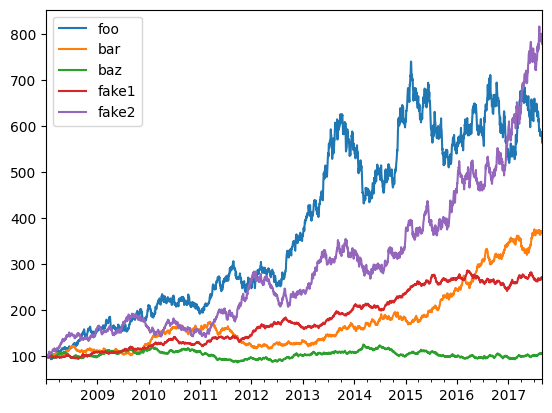

In [4]:
rf = 0.04
np.random.seed(1)
mus = np.random.normal(loc=0.05, scale=0.02, size=5) + rf
sigmas = (mus - rf) / 0.3 + np.random.normal(loc=0.0, scale=0.01, size=5)

num_years = 10
num_months_per_year = 12
num_days_per_month = 21
num_days_per_year = num_months_per_year * num_days_per_month

rdf = pd.DataFrame(
    index=pd.date_range(
        start="2008-01-02",
        periods=num_years * num_months_per_year * num_days_per_month,
        freq="B",
    ),
    columns=["foo", "bar", "baz", "fake1", "fake2"],
)

for i, mu in enumerate(mus):
    sigma = sigmas[i]
    rdf.iloc[:, i] = np.random.normal(
        loc=mu / num_days_per_year,
        scale=sigma / np.sqrt(num_days_per_year),
        size=rdf.shape[0],
    )
pdf = np.cumprod(1 + rdf) * 100
pdf.iloc[0, :] = 100

pdf.plot();

In [5]:
from bt.algos.flow import RunMonthly
from bt.algos.selection import SelectAll
from bt.algos.portfolio_ops import Rebalance
from bt.algos.weighting import WeighEqually, WeighInvVol
from bt.core.strategy import Strategy
from bt.engine import Backtest
import bt

In [6]:
strategy_names = np.array(["Equal Weight", "Inv Vol"])

runMonthlyAlgo = RunMonthly(run_on_first_date=True, run_on_end_of_period=True)
selectAllAlgo = SelectAll()
rebalanceAlgo = Rebalance()

strats = []
tests = []

for i, s in enumerate(strategy_names):
    if s == "Equal Weight":
        wAlgo = WeighEqually()
    elif s == "Inv Vol":
        wAlgo = WeighInvVol()

    strat = Strategy(str(s), [runMonthlyAlgo, selectAllAlgo, wAlgo, rebalanceAlgo])
    strats.append(strat)

    t = Backtest(strat, pdf, integer_positions=False, progress_bar=False)
    tests.append(t)

In [13]:
combined_strategy = Strategy(
    "Combined",
    algos=[runMonthlyAlgo, selectAllAlgo, WeighEqually(), rebalanceAlgo],
    children=strats,
)

combined_test = Backtest(
    combined_strategy, pdf, integer_positions=False, progress_bar=False
)

res = bt.run(combined_test)

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


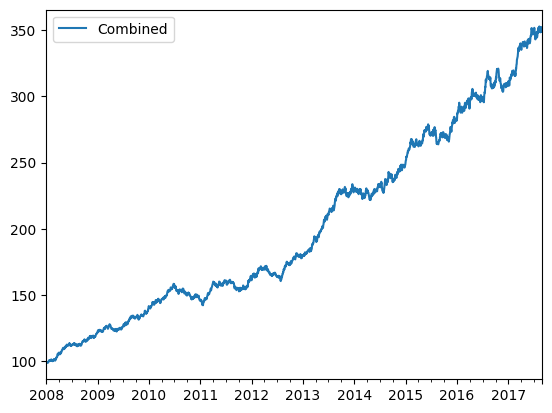

In [14]:
res.prices.plot();

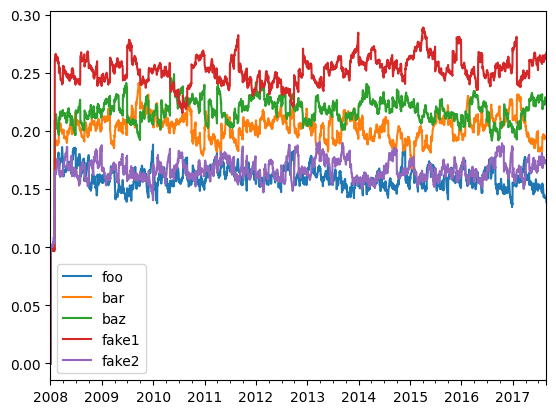

In [9]:
res.get_security_weights().plot();

In order to get the weights of each strategy, you can run each strategy, get the prices for each strategy, combine them into one price dataframe, run the combined strategy on the new data set. 

In [10]:
strategy_names = np.array(["Equal Weight", "Inv Vol"])

runMonthlyAlgo = RunMonthly(run_on_first_date=True, run_on_end_of_period=True)
selectAllAlgo = SelectAll()
rebalanceAlgo = Rebalance()

strats = []
tests = []
results = []

for i, s in enumerate(strategy_names):
    if s == "Equal Weight":
        wAlgo = WeighEqually()
    elif s == "Inv Vol":
        wAlgo = WeighInvVol()

    strat = Strategy(s, [runMonthlyAlgo, selectAllAlgo, wAlgo, rebalanceAlgo])
    strats.append(strat)

    t = Backtest(strat, pdf, integer_positions=False, progress_bar=False)
    tests.append(t)

    res = bt.run(t)
    results.append(res)

100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


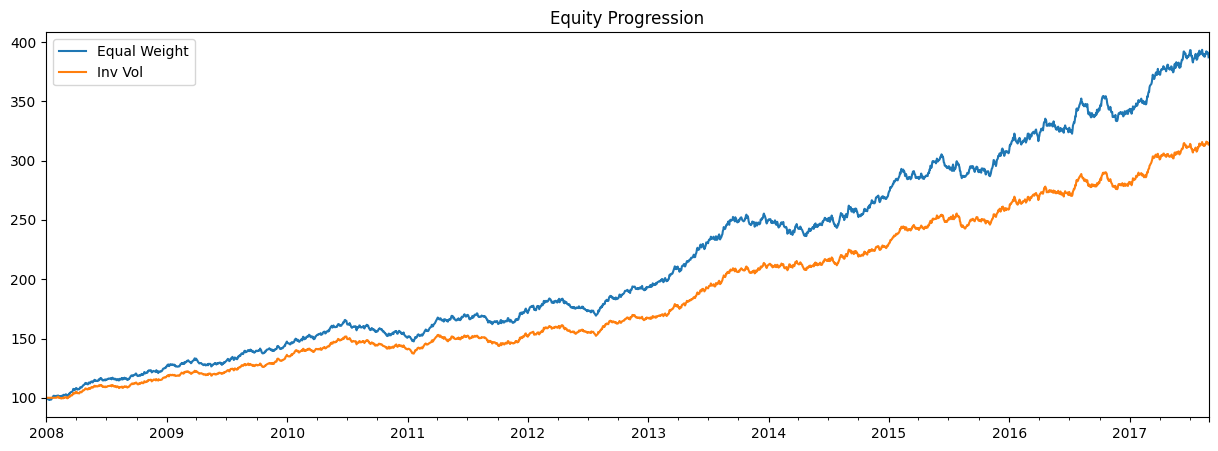

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for i, r in enumerate(results):
    r.plot(ax=ax)

In [12]:
merged_prices_df = bt.merge(results[0].prices, results[1].prices)

combined_strategy = bt.Strategy(
    "Combined",
    algos=[runMonthlyAlgo, selectAllAlgo, bt.algos.WeighEqually(), rebalanceAlgo],
)

combined_test = bt.Backtest(
    combined_strategy, merged_prices_df, integer_positions=False, progress_bar=False
)

res = bt.run(combined_test)

AttributeError: module 'bt' has no attribute 'merge'

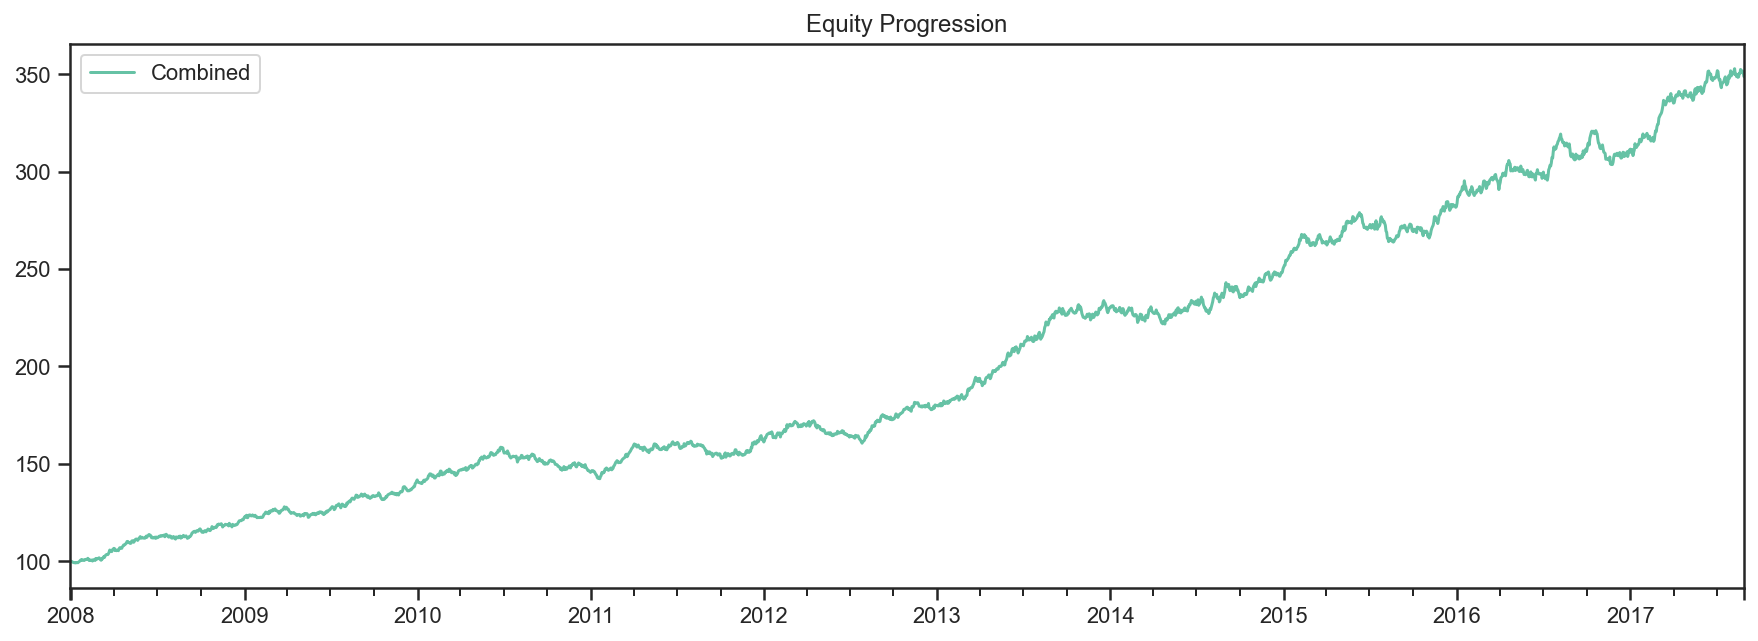

In [ ]:
res.plot();

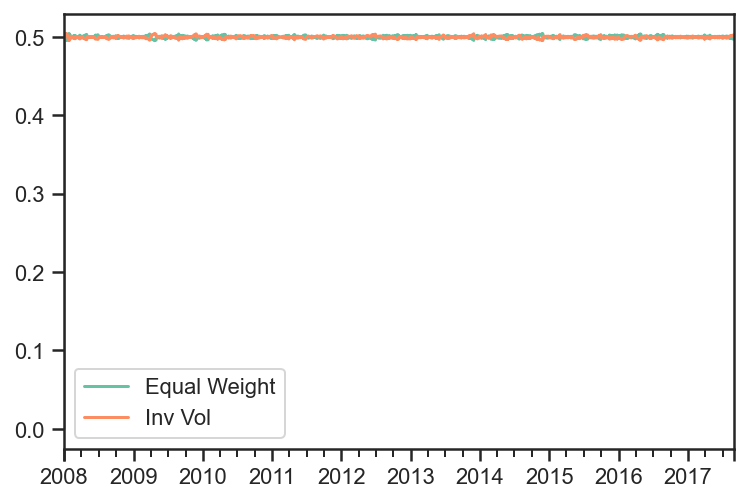

In [ ]:
res.get_security_weights().plot();